In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import pandas as pd
import numpy as np

from torch.utils.data import Dataset,DataLoader
import cv2

import os
from glob import glob

import warnings 
warnings.filterwarnings(action="ignore")

In [28]:
from PIL import Image

class CustomizeDataset(Dataset):
    def __init__(self,img_paths,labels,transforms=None):
        self.img_paths=img_paths
        self.labels=labels
        self.transforms=transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        path=self.img_paths[idx]
        img = Image.open(path).convert("RGB")

        target_list=self.labels[idx]

        if self.transforms is not None:
            img=self.transforms(img)

        return img,target_list

In [2]:
annotation=pd.read_csv('/home/irteam/junghye-dcloud-dir/Pixt/MotionExcluded/dataset/label_0528.csv')

In [5]:
import re 

img_paths=[]

labels=[]

all_img_paths=glob("/home/irteam/junghye-dcloud-dir/Pixt/MotionExcluded/dataset/dataset1/*.webp")
pattern = re.compile(r'\(\d+\)')

img_paths=[file_path for file_path in all_img_paths if not pattern.search(file_path)]

img_paths=sorted(img_paths,key=lambda x: int(x.split('/')[-1].split('.')[0]))


for index, row in annotation.query("Dataset=='dataset1'")[['Tags']].iterrows():
  tags=eval(row['Tags'])
  labels.append(tags)

In [6]:
df=pd.DataFrame(columns=['img_path','label'])
df['img_path']=img_paths
df['label']=labels

#for i in range(df.shape[0]):
 # df.loc[i]['label']=le.fit_transform(df.loc[i]['label'])

df.head()

,img_path,label
0,/home/irteam/junghye-dcloud-dir/Pixt/MotionExc...,"[조명, 나무, 모션, 그린스크린, 겨울, 크리스마스, 산타, 캐롤, 모션그래픽, ..."
1,/home/irteam/junghye-dcloud-dir/Pixt/MotionExc...,"[시골, 일몰, 마을, 구름, 지붕, 전경, 산, 강물, 강, 타임랩스, 강가, 저..."
2,/home/irteam/junghye-dcloud-dir/Pixt/MotionExc...,"[바다, 농사, 드론, 갯벌, 염전, 곰소, 소금, 바닷물, 천일염, 서해안, 신안]"
3,/home/irteam/junghye-dcloud-dir/Pixt/MotionExc...,"[나무, 일몰, 자연, 바다, 해, 산, 노을, 바닷가, 소나무, 석양, 변산, 전..."
4,/home/irteam/junghye-dcloud-dir/Pixt/MotionExc...,"[인물, 그린스크린, 손, 손가락, 제스쳐, 비비다, 크로마키]"


In [7]:
train_dataset=CustomizeDataset(df['img_path'].values,df['label'].values)

In [8]:
image,labels=train_dataset[210]

In [9]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

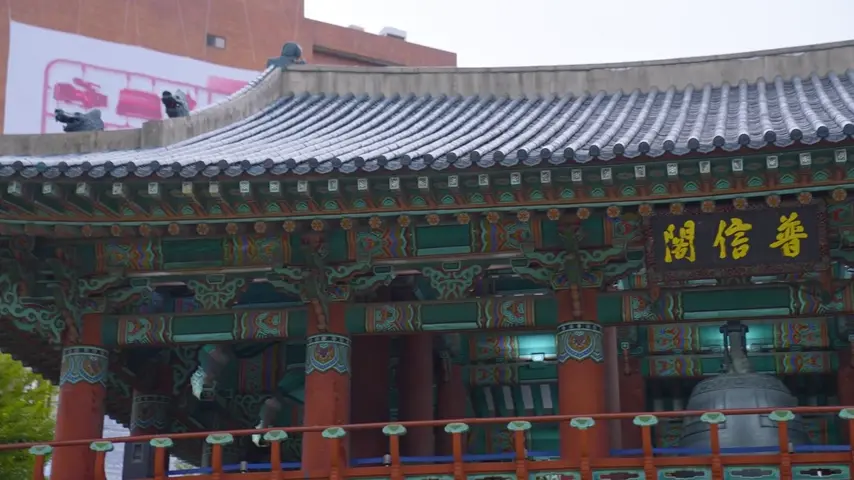

In [10]:
image

In [17]:
labels

['문화', '한옥', '문화재', '서울', '기와', '조선', '새해', '목재', '종', '종로', '보신각', '목조', '기둥']

In [12]:
import googletrans

translator=googletrans.Translator()

en_labels=[]
for label in labels:
    en_label=translator.translate(label,dest='en')
    en_labels.append(en_label.text)
print(en_labels)
    

['culture', 'Hanok', 'Cultural Heritage', 'seoul', 'tile', 'Shipbuilding', 'new year', 'wood', 'bell', 'Jong-ro', 'Bosingak', 'woodcarving', 'Pillar']


In [18]:
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in labels]).to(device)

In [19]:
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [20]:
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{labels[index]:>16s}:{100*value.item():.2f}%")



Top predictions:

              목재:27.61%
              한옥:23.62%
             문화재:12.65%
              조선:10.32%
             보신각:7.09%


In [16]:
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{en_labels[index]:>16s}:{100*value.item():.2f}%")


Top predictions:

           Hanok:62.84%
           seoul:34.18%
         Jong-ro:2.76%
Cultural Heritage:0.17%
            bell:0.01%


In [11]:
from sklearn import preprocessing

le=preprocessing.LabelEncoder()

from PIL import Image
class CustomizeDataset2(Dataset):
    def __init__(self,img_paths,labels,transforms=None):
        self.img_paths=img_paths
        self.labels=labels
        self.transforms=transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        path=self.img_paths[idx]
        img = Image.open(path).convert("RGB")

        target_list=le.fit_transform(self.labels[idx])
        target_tensor=torch.tensor(target_list).float()

        if self.transforms is not None:
            img=self.transforms(img)

        return img,target_tensor

In [12]:
import os
import clip

import torch

import numpy as np

from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader

from tqdm import tqdm 

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)


In [13]:
train=CustomizeDataset2(df['img_path'].values,df['label'].values,transforms=preprocess)

In [14]:
img,lbls=train[2]

In [20]:
img.shape[1]
img.shape[2]

224

In [27]:
lbls

tensor([ 4.,  2.,  3.,  0.,  9.,  1.,  7.,  5., 10.,  6.,  8.])

image의 shape이 32의 배수가 되도록 padding
모든 label의 길이가 50이 되도록 padding

In [74]:
import torch
import torch.nn.functional as F
import math
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, labels = zip(*batch)
    padded_images = []
    padded_labels=[]
    
    for img in images:
        padding1_mult = math.ceil(img.shape[1] / 32) * 32 - img.shape[1]
        padding2_mult = math.ceil(img.shape[2] / 32) * 32 - img.shape[2]
        
        pad1_left = padding1_mult // 2
        pad1_right = padding1_mult - pad1_left
        pad2_top = padding2_mult // 2
        pad2_bottom = padding2_mult - pad2_top
        
        img = F.pad(img, (pad2_top, pad2_bottom, pad1_left, pad1_right))
        padded_images.append(img)
    
    max_label_length=50

    for label in labels:
        padded_label=list(label)
        padded_label += [0] * (max_label_length - len(padded_label))  # 패딩 추가
        padded_labels.append(torch.tensor(padded_label))


    padded_labels=pad_sequence(padded_labels,batch_first=True)
    return torch.stack(padded_images), padded_labels


사이즈 확인

In [76]:
for images, labels in tqdm(DataLoader(train, batch_size=100,collate_fn=collate_fn)):
    print(labels.shape)

  2%|▎         | 1/40 [00:01<00:49,  1.28s/it]

torch.Size([100, 50])


  5%|▌         | 2/40 [00:02<00:46,  1.22s/it]

torch.Size([100, 50])


  8%|▊         | 3/40 [00:03<00:45,  1.24s/it]

torch.Size([100, 50])


  8%|▊         | 3/40 [00:04<00:57,  1.55s/it]


KeyboardInterrupt: 

In [77]:
for images, labels in tqdm(DataLoader(train, batch_size=100,collate_fn=collate_fn)):
    print(images.shape)

  2%|▎         | 1/40 [00:01<00:49,  1.26s/it]

torch.Size([100, 3, 224, 224])


  5%|▌         | 2/40 [00:02<00:46,  1.23s/it]

torch.Size([100, 3, 224, 224])


  8%|▊         | 3/40 [00:03<00:47,  1.27s/it]

torch.Size([100, 3, 224, 224])


KeyboardInterrupt: 

In [78]:

train=CustomizeDataset2(df['img_path'].values,df['label'].values,transforms=preprocess)
def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100,collate_fn=collate_fn)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)
            
        all_features=torch.cat(all_features)
        all_labels = torch.cat(all_labels)
    return all_features.cpu().numpy(), all_labels.cpu().numpy()


test_features, test_labels = get_features(train)



100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


In [80]:
test_features.shape

(3963, 512)

In [86]:
test_labels.shape

(3963, 50)

In [88]:
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(test_features,test_labels)

# evaluate

predictions=classifier.predict(test_features)
accuracy=np.mean((test_labels==predictions).astype(float))*100.
print(f"Accuracy = {accuracy:.3f}")


ValueError: y should be a 1d array, got an array of shape (3963, 50) instead.